# 1. Load the Saved Correlation Matrices

In [7]:
import numpy as np
import os

# Directory and mapping of types to actual filenames
corr_dir = os.path.expanduser("~/correlation_matrices")

#The correlation_types dictionary maps the types of correlation matrices to their corresponding file names.
correlation_types = {
    "correlation": "correlation_correlation_matrices.npz",
    "partial correlation": "partial correlation_correlation_matrices.npz",
    "tangent": "tangent_correlation_matrices.npz"
}

correlation_matrices = {}
'''
Loop through correlation types, load each matrix, 
and store it in the correlation_matrices dictionary while printing its shape.
'''
 
for kind, filename in correlation_types.items():
    path = os.path.join(corr_dir, filename)
    data = np.load(path)
    correlation_matrices[kind] = data["matrices"]
    print(f"{kind}: {correlation_matrices[kind].shape}")


correlation: (155, 39, 39)
partial correlation: (155, 39, 39)
tangent: (155, 39, 39)


Each matrix has the shape (155, 39, 39), which means:

- 155 subjects

- 39 regions (nodes)

- 39 regions (again since its a correlation matrix, indicating the relationship between regions, since it’s a correlation matrix)

# 2. Compute PCA-based node features from each subject's correlation matrix

- PCA (Principal Component Analysis) is a dimensionality reduction technique. In simple terms, it helps simplify data by reducing the number of features while retaining the most important information.

- Here, each region;s correlation matrix (with 39 regions) is reduced into 10 principal components (most important directions of variation) and drops the less important ones.

In [9]:
from sklearn.decomposition import PCA

# Use correlation matrix 
kind = "correlation"
matrices = correlation_matrices[kind]  # shape: (155, 39, 39)

# Set number of PCA features per node
n_components = 10

# Store PCA features per subject
pca_node_features = []

'''
For each subject's correlation matrix:
We apply PCA on the matrix using pca.fit_transform(subj_matrix).
PCA reduces each region's (node's) correlation matrix to 10 features (n_components = 10).
'''

for subj_matrix in matrices:
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(subj_matrix)  # shape: (39, n_components)
    pca_node_features.append(transformed)

pca_node_features = np.array(pca_node_features)  # shape: (155, 39, 10)
print(" PCA node features shape:", pca_node_features.shape)


 PCA node features shape: (155, 39, 10)


- We are reducing the correlation matrix of each subject (with 39 regions) to 10 PCA features per region.

- This will help in making the node features more compact and useful for the graph-based classification model (GCN).

- Final shape of pca_node_features:
   - 155 subjects
   - 39 regions/nodes
   - 10 PCA features per region

# 3. Save Features

In [12]:
# Save PCA node features for "correlation"
np.savez_compressed(save_path, features=pca_node_features)
print(f" Saved PCA node features to: {save_path}")


 Saved PCA node features to: /Users/anushamourshed/graph_data/correlation_pca_node_features.npz


# 4. Repeat PCA process for partial and tangent correlation

In [14]:
# Step 4: Compute PCA node features for "partial correlation"
kind = "partial correlation"
matrices = correlation_matrices[kind]
n_components = 10

pca_node_features = []

for subj_matrix in matrices:
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(subj_matrix)
    pca_node_features.append(transformed)

pca_node_features = np.array(pca_node_features)
print(f" PCA node features shape for '{kind}':", pca_node_features.shape)


 PCA node features shape for 'partial correlation': (155, 39, 10)


In [17]:
np.savez_compressed(save_path, features=pca_node_features)
print(f" Saved PCA node features to: {save_path}")


 Saved PCA node features to: /Users/anushamourshed/graph_data/partial_correlation_pca_node_features.npz


In [19]:
# Compute PCA node features for "tangent"
kind = "tangent"
matrices = correlation_matrices[kind]
n_components = 10

pca_node_features = []

for subj_matrix in matrices:
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(subj_matrix)
    pca_node_features.append(transformed)

pca_node_features = np.array(pca_node_features)
print(f"PCA node features shape for '{kind}':", pca_node_features.shape)


PCA node features shape for 'tangent': (155, 39, 10)


In [22]:
np.savez_compressed(save_path, features=pca_node_features)
print(f"Saved PCA node features to: {save_path}")


Saved PCA node features to: /Users/anushamourshed/graph_data/tangent_pca_node_features.npz


# 5. Define correlation types, threshold values, and load PCA features

In [23]:
import numpy as np
import os

# Define correlation types and threshold values 
correlation_types = ["correlation", "partial correlation", "tangent"]
threshold_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # adjust if needed

# set up Paths for the Matrices and PCA Features
corr_dir = os.path.expanduser("~/correlation_matrices") #Correlation matrices path
feature_dir = os.path.expanduser("~/graph_data") #PCA node feature path

# Load correlation matrices
correlation_matrices = {}
for kind in correlation_types:
    filename = f"{kind}_correlation_matrices.npz"
    path = os.path.join(corr_dir, filename)
    correlation_matrices[kind] = np.load(path)["matrices"]

# Load PCA node features
pca_node_features = {}
for kind in correlation_types:
    filename = f"{kind.replace(' ', '_')}_pca_node_features.npz"
    path = os.path.join(feature_dir, filename)
    pca_node_features[kind] = np.load(path)["features"]

print("✅ Loaded everything")


✅ Loaded everything


# 6. Convert to graph

For each subject, turn their:

- Correlation matrix → a graph structure (edges)

- PCA features → node attributes

- Label → class (child or adult)

- into a usable torch_geometric.data.Data object.

In [24]:
import torch
from torch_geometric.data import Data

#create a graph for each subject 
def create_graph_data(adjacency_matrices, node_features, labels, threshold):
    graph_data = []
    n_subjects = adjacency_matrices.shape[0]

    '''
    Loop Through Each Subject: 
    For each subject, you extract the corresponding correlation matrix (adj) 
    and PCA node features (features)
    '''
    for i in range(n_subjects):
        adj = adjacency_matrices[i]
        features = node_features[i]

        # Apply threshold (absolute value)
        binary_adj = (np.abs(adj) >= threshold).astype(int)

        # Remove self-loops
        '''
        Since a node should not have a connection to itself
        we set the diagonal of the adjacency matrix to zero.
        '''
        np.fill_diagonal(binary_adj, 0)

        # Convert adjacency matrix to edge index format 
        edge_index = np.array(np.nonzero(binary_adj))
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Node features
        '''
        The PCA node features for the subject are stored as x,
        which are converted into a tensor.
        '''
        x = torch.tensor(features, dtype=torch.float)

        # Label
        '''
        The label for the subject is stored as y,
        also converted into a tensor
        '''
        y = torch.tensor([labels[i]], dtype=torch.long)

        # Create PyG graph
        data = Data(x=x, edge_index=edge_index, y=y)
        graph_data.append(data)

    return graph_data


# 7. Load Labels

In [25]:
# Load subject labels (0 = child, 1 = adult)
labels_path = os.path.expanduser("~/time_series_data/subject_labels.npy")
subject_labels = np.load(labels_path)

print("✅ Labels loaded. Shape:", subject_labels.shape)
print("👶 # Children:", np.sum(subject_labels == 0))
print("🧑 # Adults:", np.sum(subject_labels == 1))


✅ Labels loaded. Shape: (155,)
👶 # Children: 122
🧑 # Adults: 33


- 155 subjects
- 122 children
- 33 adults

# 8. Preparing Graph Datasets for All Correlation - Threshold Combinations

In [26]:
from sklearn.model_selection import train_test_split

# Use this to store all combinations
graph_dataset_dict = {}

# Use stratified train/test split
'''
train_idx, test_idx = train_test_split(...) splits the subjects 
into training and test sets while preserving the ratio of children
and adults (stratify=subject_labels).

The test_size=0.2 means 20% of the data will be used for testing 
and the rest will be for training.
'''
train_idx, test_idx = train_test_split(
    np.arange(len(subject_labels)),
    test_size=0.2,
    stratify=subject_labels,
    random_state=42 #controls randomness and sets it to 42 to get same split each time
)


# loop through all correlation types and threshold values 
'''
For each correlation type (kind) and threshold value, we:
- Extract the adjacency matrix (adj) and PCA features (features).
- Use the create_graph_data() function to generate all the graphs (subject-wise) 
based on the adjacency matrix, PCA features, and subject labels.
'''
for kind in correlation_types:
    for threshold in threshold_values:
        # Get adjacency and features
        adj = correlation_matrices[kind]
        features = pca_node_features[kind]

        # Create all subject graphs
        all_graphs = create_graph_data(adj, features, subject_labels, threshold)

        # Split the graphs into training and test sets
        train_graphs = [all_graphs[i] for i in train_idx]
        test_graphs = [all_graphs[i] for i in test_idx]

        # Store the dataset (each combo) in graph_dataset_dict
        key = f"{kind} | thresh={threshold}"
        graph_dataset_dict[key] = {
            "train": train_graphs,
            "test": test_graphs
        }

print(f"✅ Datasets prepared for {len(graph_dataset_dict)} combinations")


✅ Datasets prepared for 24 combinations


- 8 thresholds
- 3 correlations 
- 24 combinations

# 9. Defining the GCN Model and Training/Evaluation Pipeline

1. GCN Model Structure:
The GCN model uses GCNConv layers, which are the core components for graph convolution. The model consists of two layers:

- First Layer: Takes the input features (in_channels) and applies a graph convolution to produce hidden features (hidden_channels).

- Second Layer: Takes the hidden features and applies a second graph convolution to output the final class predictions (out_channels), which in this case is 2 (for children and adults).

In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

# GCN Model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    '''
    The forward() function defines how data flows through the layers:

    The input features x pass through the first and second convolution layers (conv1, conv2), 
    with ReLU activation (sets negative values to 0) applied between the two layers.
    '''
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Train & evaluate function

'''
- The model is trained for a fixed number of epochs (epochs), where it processes the train graphs.
- For each graph, the optimizer updates the model’s weights to minimize the cross-entropy loss between predicted outputs and actual labels.
- After each forward pass, the node outputs are averaged to produce a graph-level prediction (mean over nodes).
'''

def train_and_evaluate(train_graphs, test_graphs, input_dim, hidden_dim=16, epochs=30):
    model = GCN(in_channels=input_dim, hidden_channels=hidden_dim, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_graphs:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            # Graph classification: take mean over node outputs
            out = out.mean(dim=0, keepdim=True)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    # Evaluation

    '''
    - During evaluation (model.eval()), the model’s weights are frozen (no gradient calculation).
    - The predictions are made for the test graphs, and the accuracy is calculated by comparing predicted labels with actual labels.
    '''
    model.eval()
    correct = 0
    total = len(test_graphs)
    with torch.no_grad():
        for data in test_graphs:
            out = model(data.x, data.edge_index)
            pred = out.mean(dim=0, keepdim=True).argmax(dim=1)
            correct += int(pred == data.y)

    return correct / total


# Training and Evaluating the GCN Model on All Graph Dataset Variants

In [29]:
# stores the accuracy for each combination of correlation type and threshold
results = {}

# Loop through each combination
for combo_key, data in graph_dataset_dict.items():
    # train_graphs and test_graphs extracted from graph_dataset_dict
    train_graphs = data["train"]
    test_graphs = data["test"]

    # retrieves the number of features for each node (which is 10 due to PCA)
    input_dim = train_graphs[0].x.shape[1]  
    '''
    The train_and_evaluate() function is called to train and evaluate the model 
    on the current combination of train graphs and test graphs.
     
    The result (accuracy) is stored in results under the key combo_key.
    '''
    accuracy = train_and_evaluate(train_graphs, test_graphs, input_dim)
    results[combo_key] = accuracy

    print(f"{combo_key}: 🔍 Accuracy = {accuracy:.4f}")


correlation | thresh=0.2: 🔍 Accuracy = 0.7742
correlation | thresh=0.3: 🔍 Accuracy = 0.6774
correlation | thresh=0.4: 🔍 Accuracy = 0.6129
correlation | thresh=0.5: 🔍 Accuracy = 0.5806
correlation | thresh=0.6: 🔍 Accuracy = 0.7419
correlation | thresh=0.7: 🔍 Accuracy = 0.7419
correlation | thresh=0.8: 🔍 Accuracy = 0.7097
correlation | thresh=0.9: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.2: 🔍 Accuracy = 0.6774
partial correlation | thresh=0.3: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.4: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.5: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.6: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.7: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.8: 🔍 Accuracy = 0.7742
partial correlation | thresh=0.9: 🔍 Accuracy = 0.7742
tangent | thresh=0.2: 🔍 Accuracy = 0.7742
tangent | thresh=0.3: 🔍 Accuracy = 0.7742
tangent | thresh=0.4: 🔍 Accuracy = 0.7742
tangent | thresh=0.5: 🔍 Accuracy = 0.7742
tangent | thresh=0.6: 🔍 Accuracy

### 🧠 Insights:

- Tangent and Partial Correlation give very stable performance — all thresholds hit 77.42%

- Full Correlation is more sensitive to thresholds:

   - Best: 0.2 and 0.9 = 77.42%

   - Worst: 0.5 = 58.06%

# Visualize

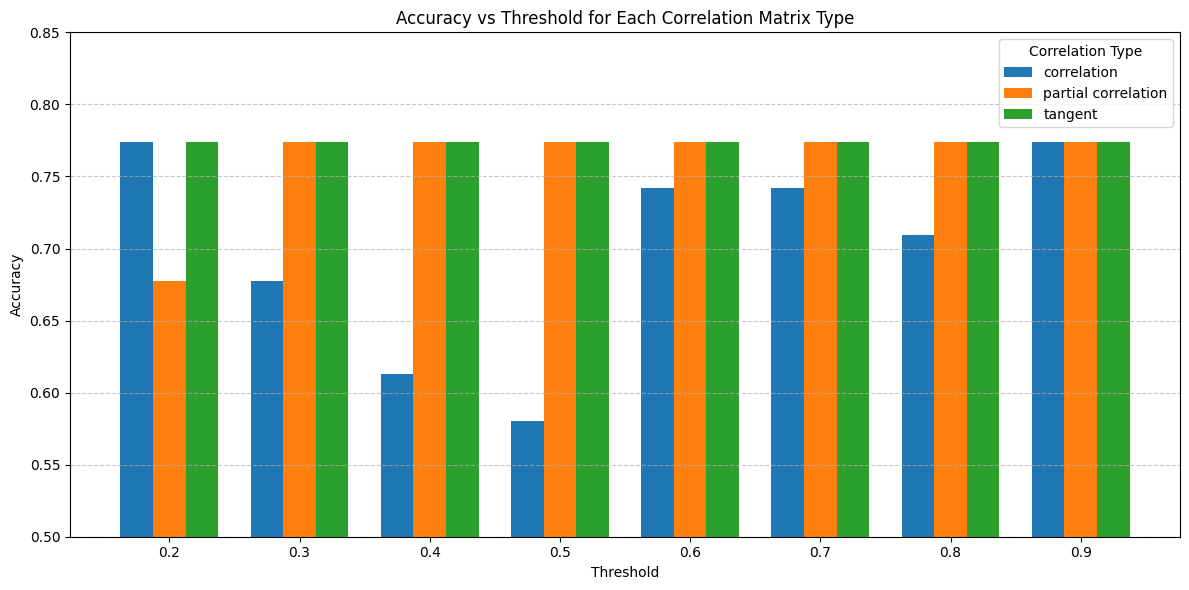

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Sort threshold values for consistent ordering
thresholds = sorted(threshold_values)
correlation_types = ["correlation", "partial correlation", "tangent"]

# Bar settings
bar_width = 0.25
x = np.arange(len(thresholds))  # one x-position per threshold

# Offset each group on the x axis so bars dont overlap
offsets = {
    "correlation": -bar_width,
    "partial correlation": 0,
    "tangent": bar_width
}

# Plot initialization (12x6)
plt.figure(figsize=(12, 6))

#loop through each correlation type and retrieve corresponding accuracy for each threshold
for kind in correlation_types:
    accs = [results[f"{kind} | thresh={thresh}"] for thresh in thresholds]
    plt.bar(x + offsets[kind], accs, width=bar_width, label=kind)

# Axis formatting
plt.title("Accuracy vs Threshold for Each Correlation Matrix Type")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.xticks(x, thresholds)
plt.ylim(0.5, 0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Correlation Type")
plt.tight_layout()
plt.show()


The key difference between PCA in the original notebook and the PCA on node features in this notebook lies in the input data and the context in which PCA is applied:

1. PCA in the Original Notebook:
In the original notebook, PCA was applied on time-series data for each subject (across time). Specifically, it was used to reduce the dimensionality of the time-series data for each brain region (node).

- Input: Time-series data for each subject (with shape (timepoints, regions)).

- Objective: Reduce the temporal dimension (time) and extract the most important temporal features for each brain region (node) across time.

- Result: A compressed representation of temporal patterns in each brain region.

2. PCA on Node Features in the Current Notebook:
In the current notebook, PCA is applied to the correlation matrices (computed from the original time-series data) to reduce the dimensionality of the features per node.

- Input: Correlation matrices for each subject (with shape (regions, regions)), which represent the relationships between regions across time.

- Objective: Reduce the dimensionality of the correlation matrix for each subject, where each node represents a brain region. This helps in making the graph-based classification task more efficient by focusing on the most significant relationships (features) between regions.

- Result: A set of PCA features for each node (region), which are used as input to the GCN.

Original PCA is reducing time-series data to focus on temporal patterns.

Current PCA is reducing the correlation matrix to create compact node features for graph classification.